# Principal Component Analysis (PCA) and Clustering

We will group our gym members into clusters. The idea is to use these clusters to place gym members into groups of customers that exhibit similar behaviors. This will help us identify the patterns that influence whether customer decides to stay or leave.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from plotter import * # plot_hist(), plot_box(), plot_bar(), plot_pie()

We will perform clustering on the training data. We will allocate 80% of the data set for training and the remaining 20% for testing. We will perform PCA on the features then use this to generate clusters. By creating these clusters, we hope to find behavioral patterns that help us determine whether or not a customer will leave the gym.

In [2]:
df = pd.read_csv('data/gym_churn_us.csv')
df.rename_axis('Member_ID', inplace=True)

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (3200, 13)
y_train.shape: (3200,)
X_test.shape: (800, 13)
y_test.shape: (800,)


# PCA

We will observe how different normalization techniques and how the amount of principal components impacts the clusters of our data. We will test `MinMaxScaler()`, `StandardScaler()`, and `RobustScaler()` with two and three principal components. Given that most of the data is discrete and not normally distributed, we will expect `MinMaxScaler()` and `RobustScaler()` to perform better than `StandardScaler()`.

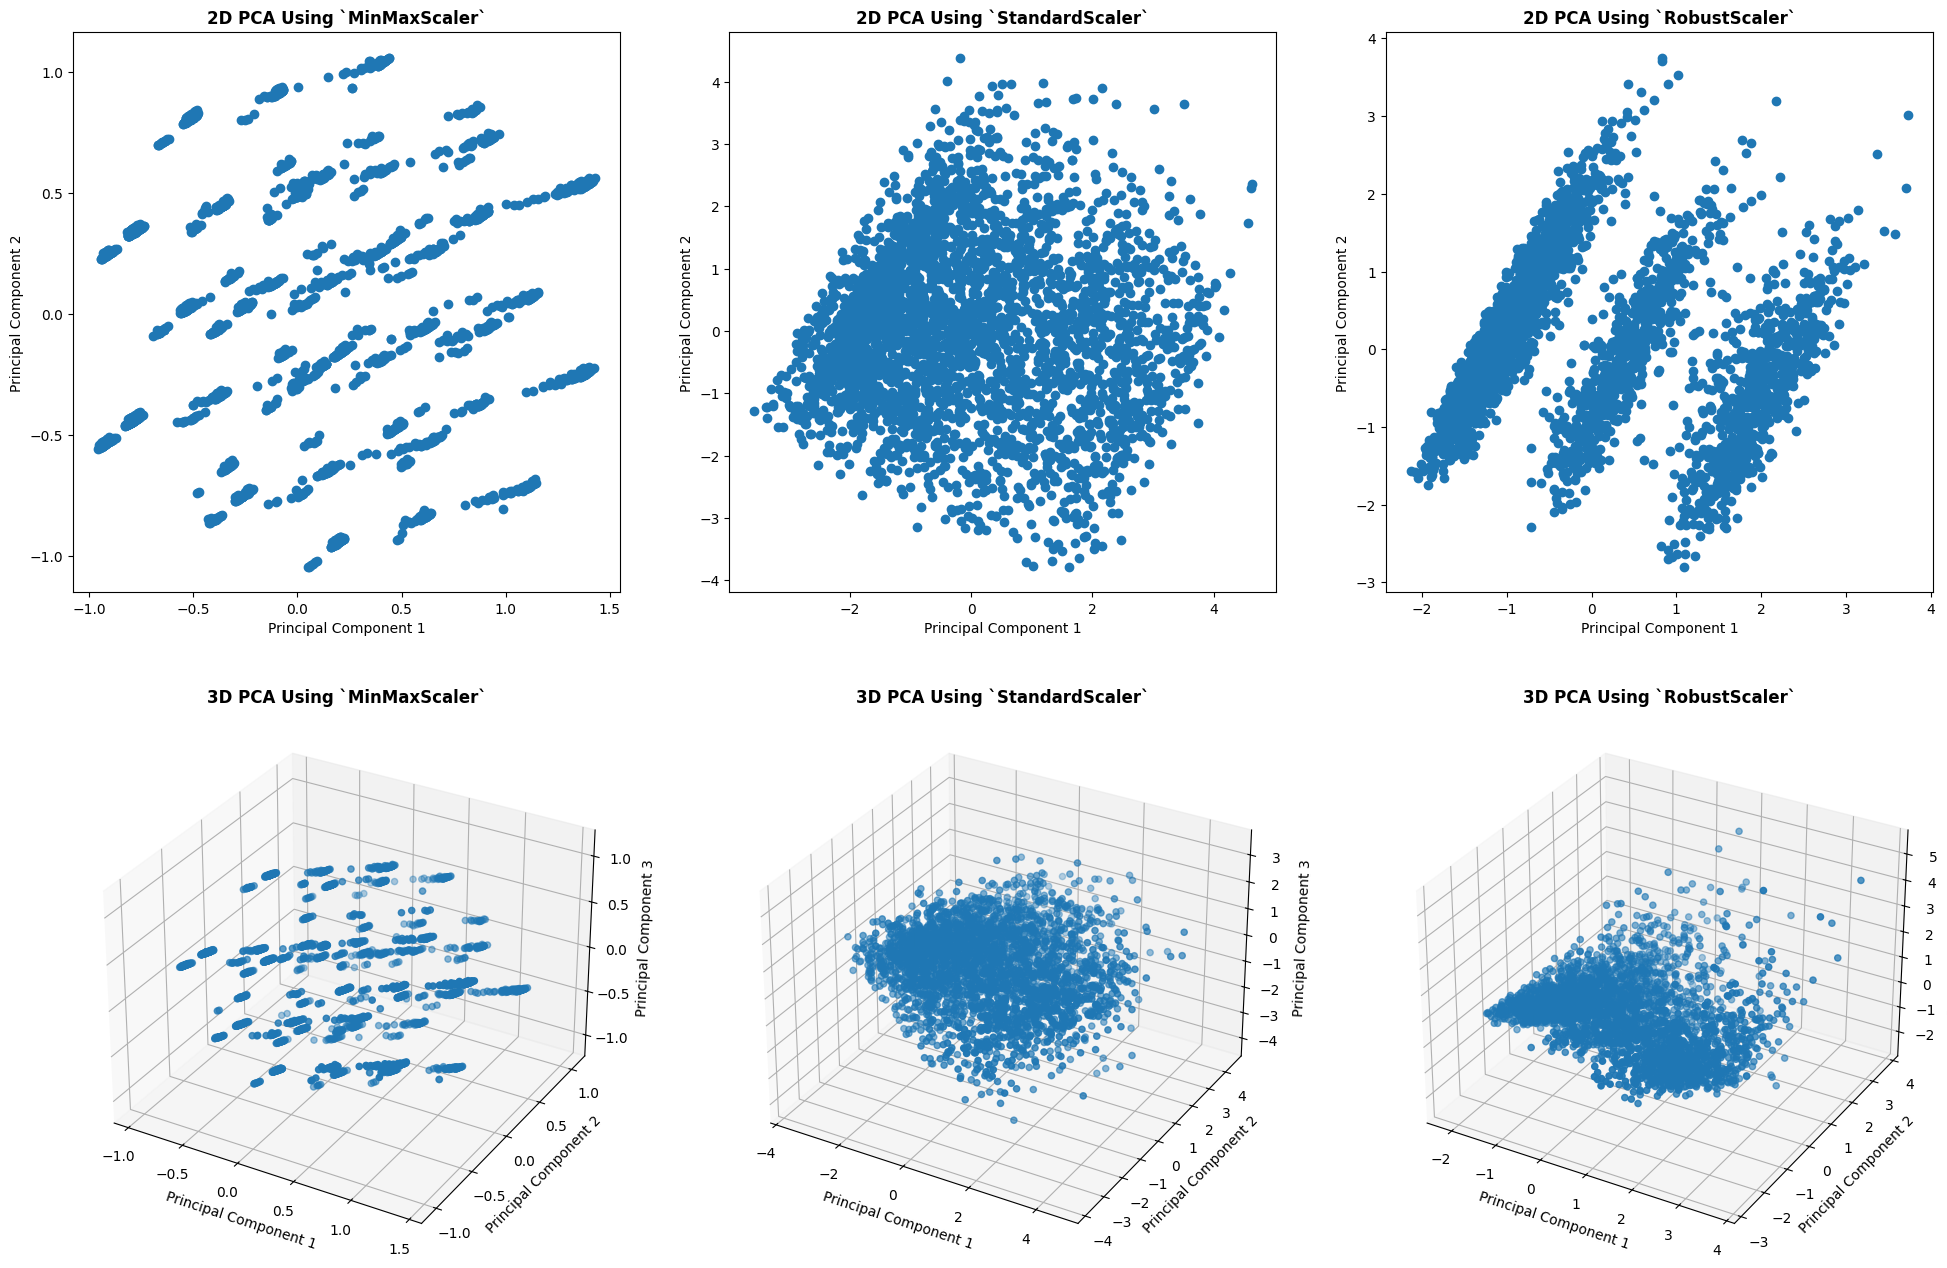

In [3]:
scalers = {'`MinMaxScaler`': MinMaxScaler(),
           '`StandardScaler`': StandardScaler(),
           '`RobustScaler`': RobustScaler()}


fig = plt.figure(figsize=(24,16))

for i, (key, value) in enumerate(scalers.items()):
    for n_components in range(2,4):
        scaler_name = key
        scaler = value

        projection = '3d' if n_components==3 else None
        ax = fig.add_subplot(2,3,(i+1)+(n_components-2)*3, projection=projection)

        X_train_norm = scaler.fit_transform(X_train)

        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_norm)
        ax.scatter(*X_train_pca.T)
        
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        if n_components == 3:
            ax.set_zlabel('Principal Component 3')
        
        ax.set_title(f'{n_components}D PCA Using {scaler_name}', fontweight='bold')

plt.show()

Using `RobustScaler()` with two principal components seems to generate the most distinct clusters (3 clusters). We will use Gaussian Mixture Models to account for the elliptical shape of the clusters. This also allows us to create soft clustres for probabilistic clustering.

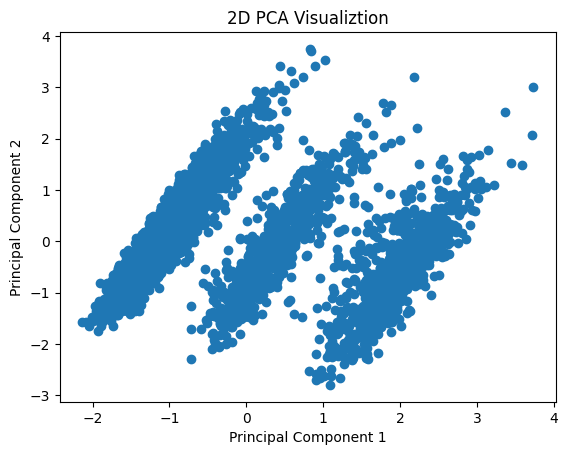

In [4]:
# perform PCA (again) to reduce dimensionality of data for visualizations
scaler = RobustScaler()
n_components = 2
pca = PCA(n_components=n_components)
X_train_norm = scaler.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_norm)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1])
plt.title('2D PCA Visualiztion')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

By using PCA, we have reduced the dimensionality of the data. We can determine the imoprtance of each feature in each principal component in the `DataFrame` below. To identify the most important feature of each principal component, we can find the feature with the highest absolute value.

In [5]:
loadings = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC{idx}' for idx in range(1, n_components+1)])
loadings.T

,PC1,PC2
gender,0.008229,0.006826
Near_Location,0.046100,-0.005586
Partner,0.132722,-0.068802
Promo_friends,0.106212,-0.042542
Phone,-0.000416,-0.003989
Contract_period,0.641689,-0.310880
Group_visits,0.085861,-0.000028
Age,0.190810,0.263147
Avg_additional_charges_total,0.099506,0.050414
Month_to_end_contract,0.586125,-0.294756


In [6]:
most_important_features = pd.DataFrame(loadings.abs().idxmax(axis=1), columns=['feature'])
most_important_features['loadings'] = [
    loadings.loc[pc, feature]
    for pc, feature in zip(most_important_features.index, most_important_features['feature'])
]

most_important_features

,feature,loadings
PC1,Contract_period,0.641689
PC2,Avg_class_frequency_total,0.514226


## `PC1`
* Most important feature: `Contract_period`
* Correltaion with `Churn`: positive (0.64)

## `PC2`
* Most important feature: `Avg_class_frequency_total`
* Correltaion with `Churn`: positive (0.51)

We only have 13 features which should be reasonably manageable. PCA was performed for the purposes of visualizing the data and find distinct patterns. We have found three distinct groups, which we hope to formally identify using clustering techniques. However, performing PCA gives us a good idea of the importnace of each feature.

# Clustering

In [7]:
# Fit GMM with 3 components
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)

# hard clusters (most probable classifications)
labels_train = gmm.fit_predict(X_train_pca)

# probabilities for soft clustering
probs_train = gmm.predict_proba(X_train_pca)

After fitting the GMM with 3 components, we plot the clusters below. The labels are obtained using the most likely classification for each member.

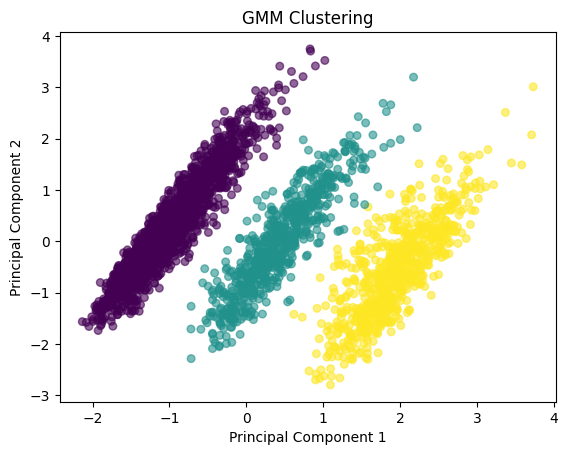

In [8]:
# plot clusters
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=labels_train, cmap='viridis', s=30, alpha=0.6)
plt.title("GMM Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Using our best estimate of each individual's cluster, we can examine the overall behaviors of each group.

In [9]:
X_train_hard_clusters = df.copy().iloc[X_train.index]
X_train_hard_clusters['Cluster'] = labels_train
X_train_hard_clusters.groupby('Cluster').mean().T

Cluster,0,1,2
gender,0.498577,0.523256,0.513907
Near_Location,0.810472,0.863372,0.936424
Partner,0.348890,0.569767,0.721854
Promo_friends,0.212863,0.376453,0.490066
Phone,0.909505,0.902616,0.913907
Contract_period,1.000000,6.130814,12.000000
Group_visits,0.344337,0.449128,0.561589
Age,28.729084,29.425872,29.770861
Avg_additional_charges_total,138.295965,149.710346,165.677338
Month_to_end_contract,1.000000,5.565407,10.965563


These clusters were generated from the features of our dataset. Something interesting is that the clusters have very different churn rates. From this dataframe, we already have a general idea of the behavioral patterns of each cluster.

### Cluster 0
* High churn rate (42.80%)
* Low commitment (short contracts and lifetime)

### Cluster 1
* Moderate churn rate (13.23%)
* Moderate commitment (average contract of 6 months)

### Cluster 2
* Low churn rate (2.65%)
* Loyal customers (12 month contracts and highest lifetime average)

To get a better understanding of the cluster behaviors, we will plot the features below.

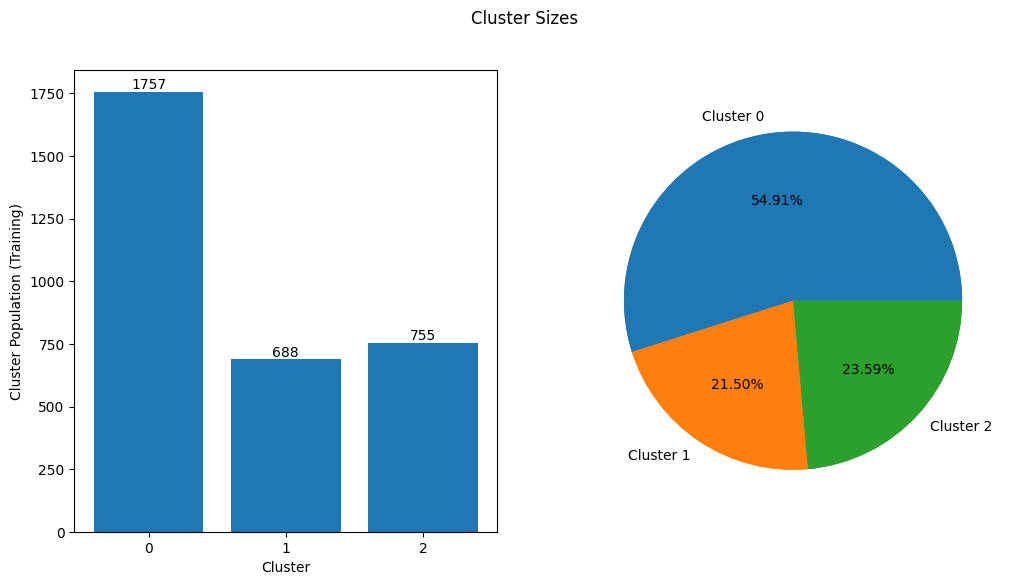

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,6))

fig.suptitle('Cluster Sizes')

train_cluster_sizes = X_train_hard_clusters.groupby('Cluster').size()

bar_plot = ax1.bar(train_cluster_sizes.index, train_cluster_sizes)
ax1.bar_label(bar_plot)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Cluster Population (Training)')
ax1.set_xticks(train_cluster_sizes.index, [f'{idx}' for idx in train_cluster_sizes.index], rotation=0)


pie_chart = ax2.pie(train_cluster_sizes)

train_cluster_sizes.plot.pie(labels=[f'Cluster {idx}' for idx in train_cluster_sizes.index],
                             autopct='%1.2f%%', ax=ax2)


plt.show()

Most of the gym's customers belong to cluster 0. This cluster makes up more than half of the training data. The other two clusters have a relatively similar amount of members.

In [11]:
quantitative_features = []
binary_features = []
for col in df.columns:
    if col != 'Churn':
        if len(df[col].unique()) > 2:
            quantitative_features.append(col)
        else:
            binary_features.append(col)
print(quantitative_features)
print(binary_features)

['Contract_period', 'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month']
['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']


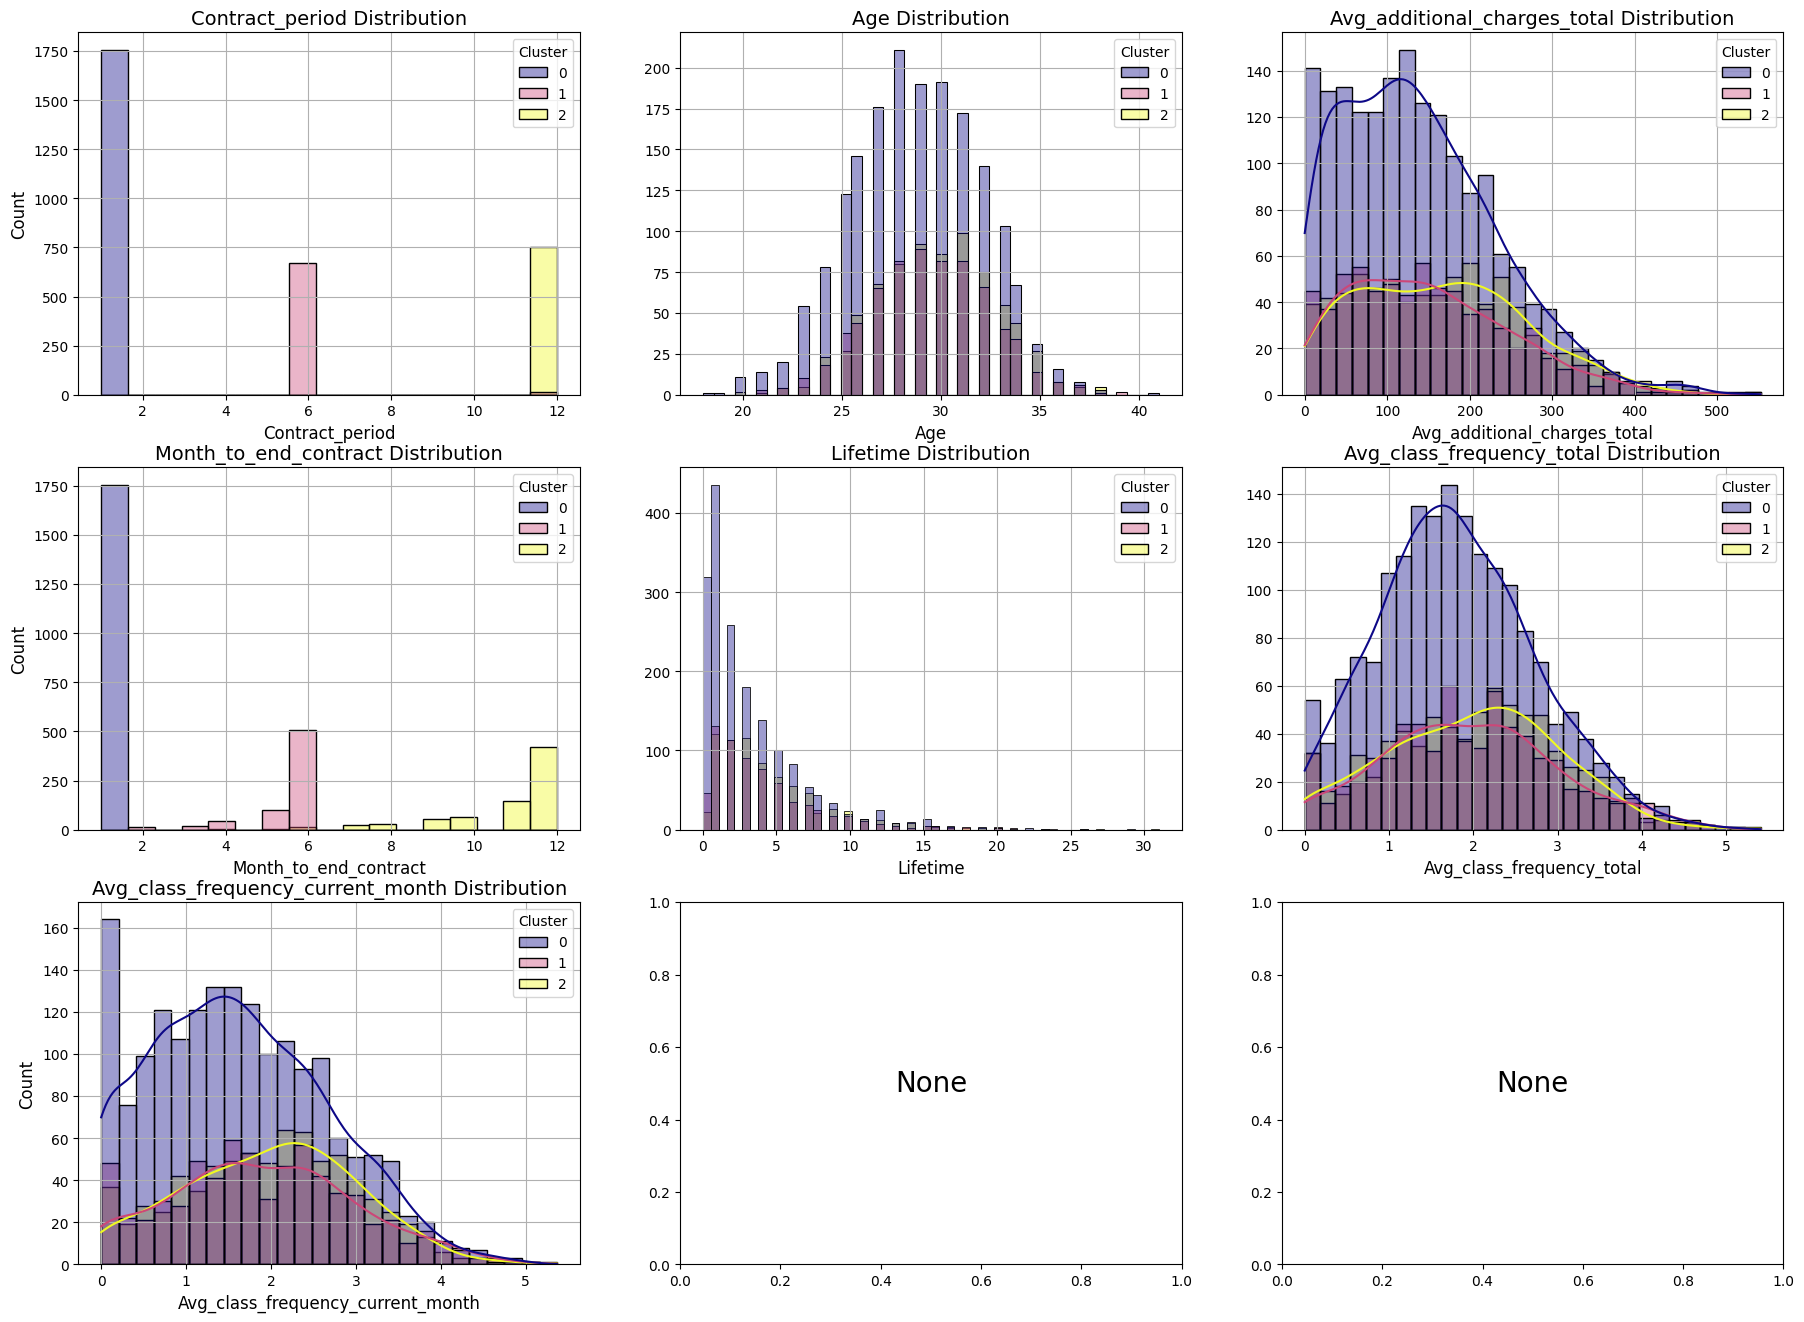

In [12]:
fig, ax = plot_hist(X_train_hard_clusters[quantitative_features+['Cluster']], hue='Cluster', palette='plasma', figsize=(22,16))
plt.show()

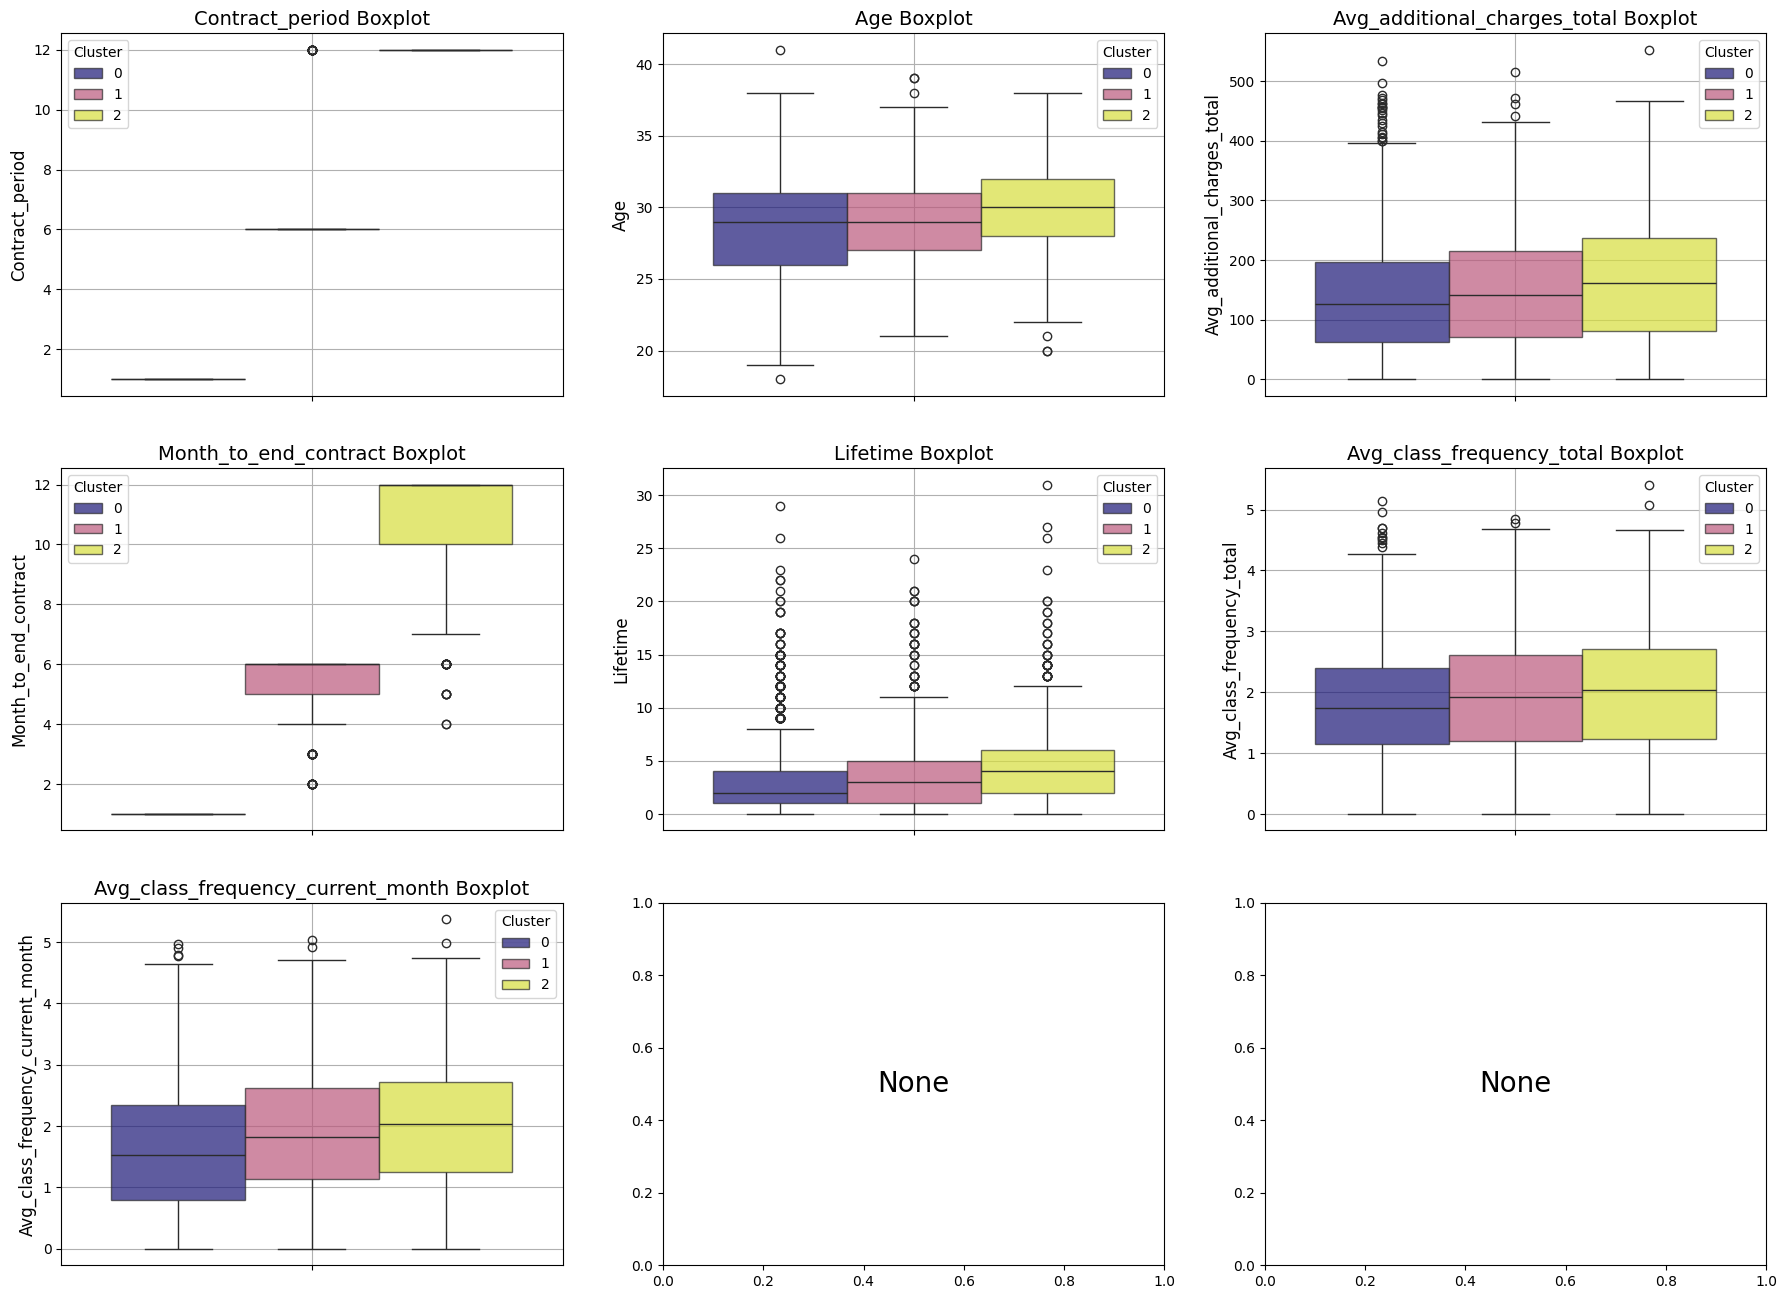

In [13]:
fig, ax = plot_box(X_train_hard_clusters[quantitative_features+['Cluster']], hue='Cluster', palette='plasma', alpha=0.7, figsize=(22,16))
plt.show()

The distributions for the features above are similar for the most part. However, there are key differences in the distributions of `Contract_period` and `Month_to_end_contract`. 

### Cluster 0
* All one month contracts
* All within one month of membership expiration

### Cluster 1
* Mostly 6  month contracts (very few 12 month contracts, no one month contracts)
* Very few members within 2 months of membership expiration in the data set

### Cluster 2
* All 12 month contracts
* None within 6 months of membership expiration in the data set

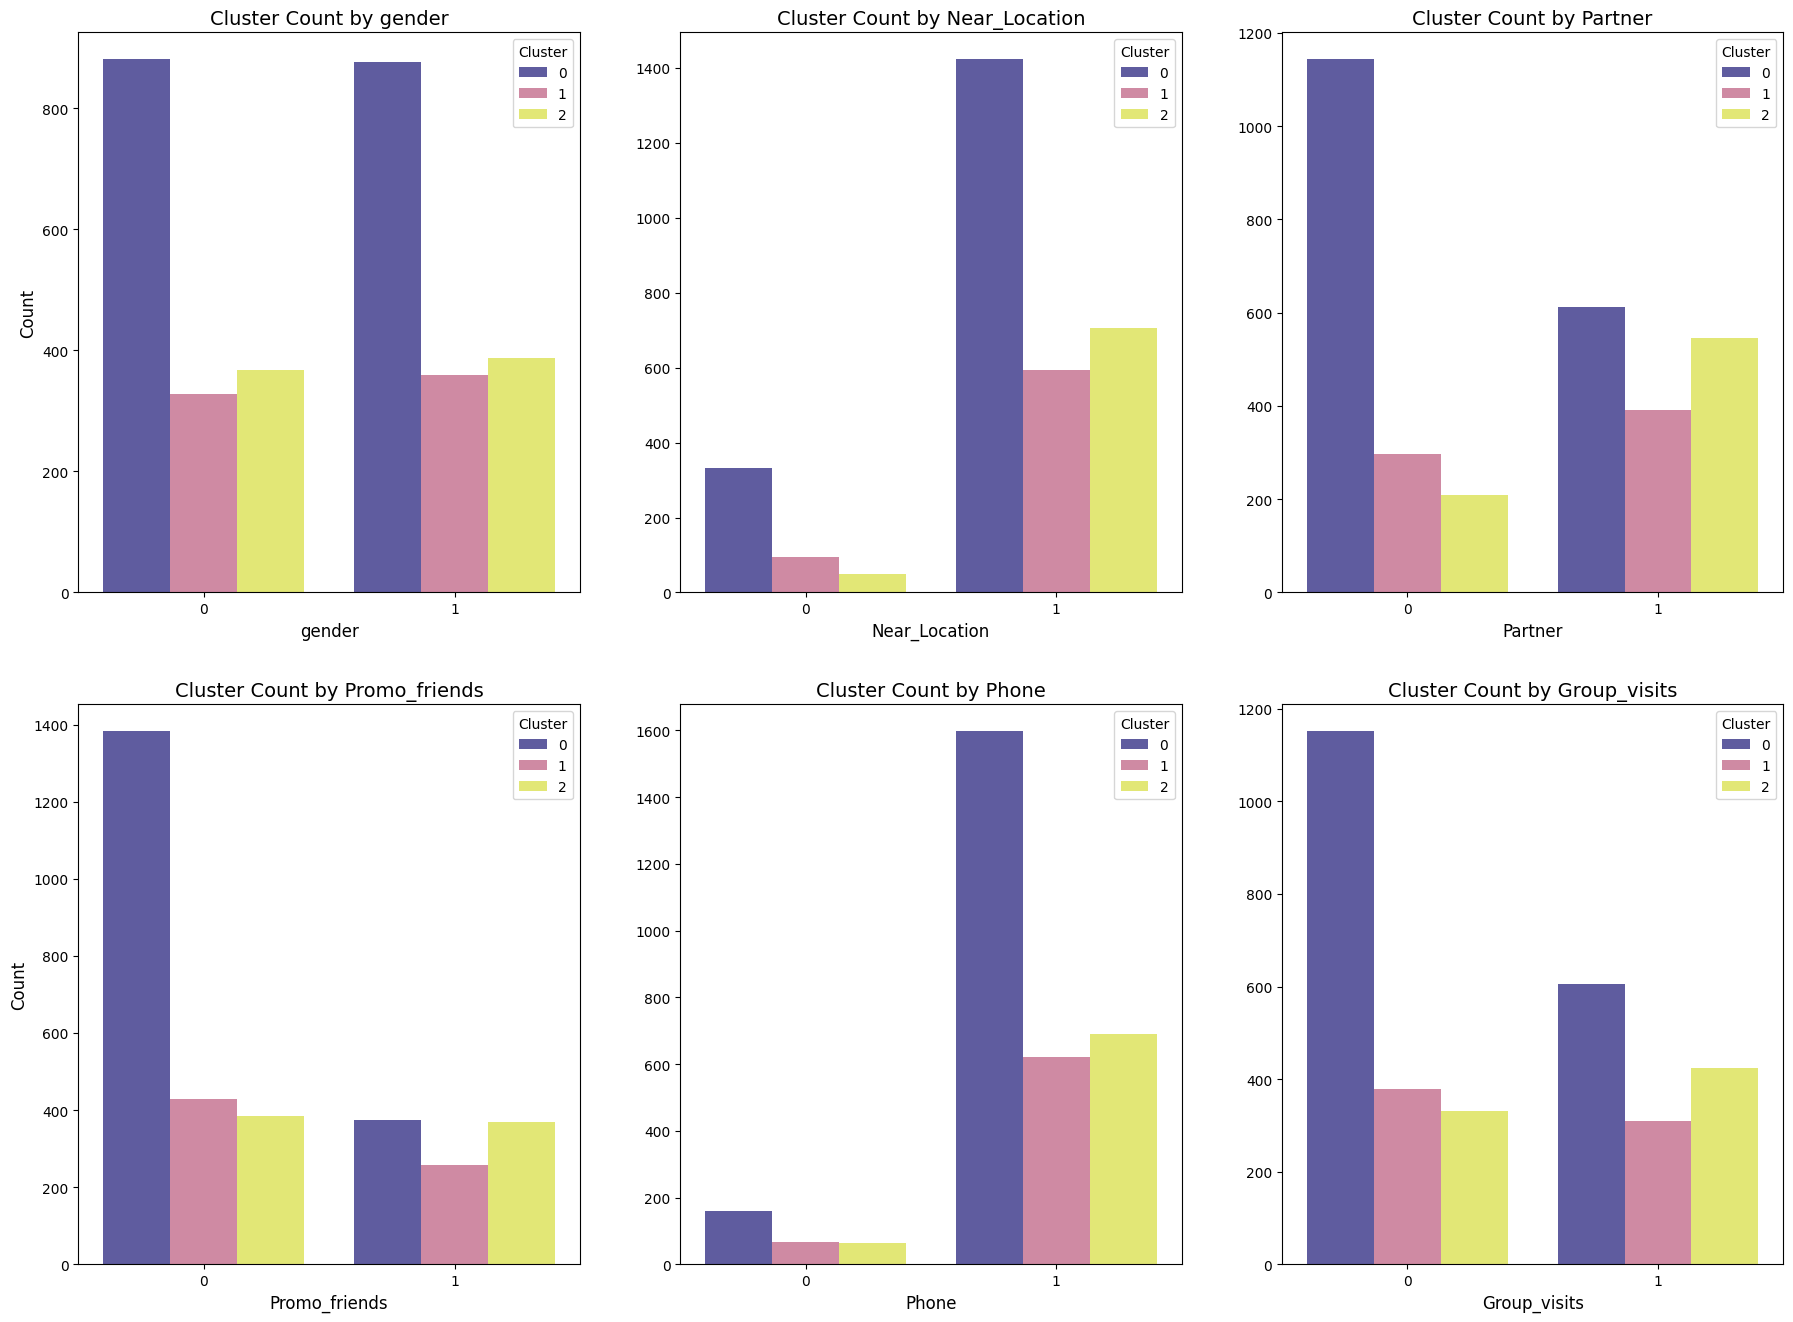

In [14]:
fig, ax = plot_bar(X_train_hard_clusters[binary_features+['Cluster']], hue='Cluster', palette='plasma', alpha=0.7, figsize=(22,16))
plt.show()

While these bar plots may be somewhat helpful, the discrepency in cluster sizes can skew our perception of the data. To fix this, we will use pie charts to visualize the distribution of the binary features in each cluster.

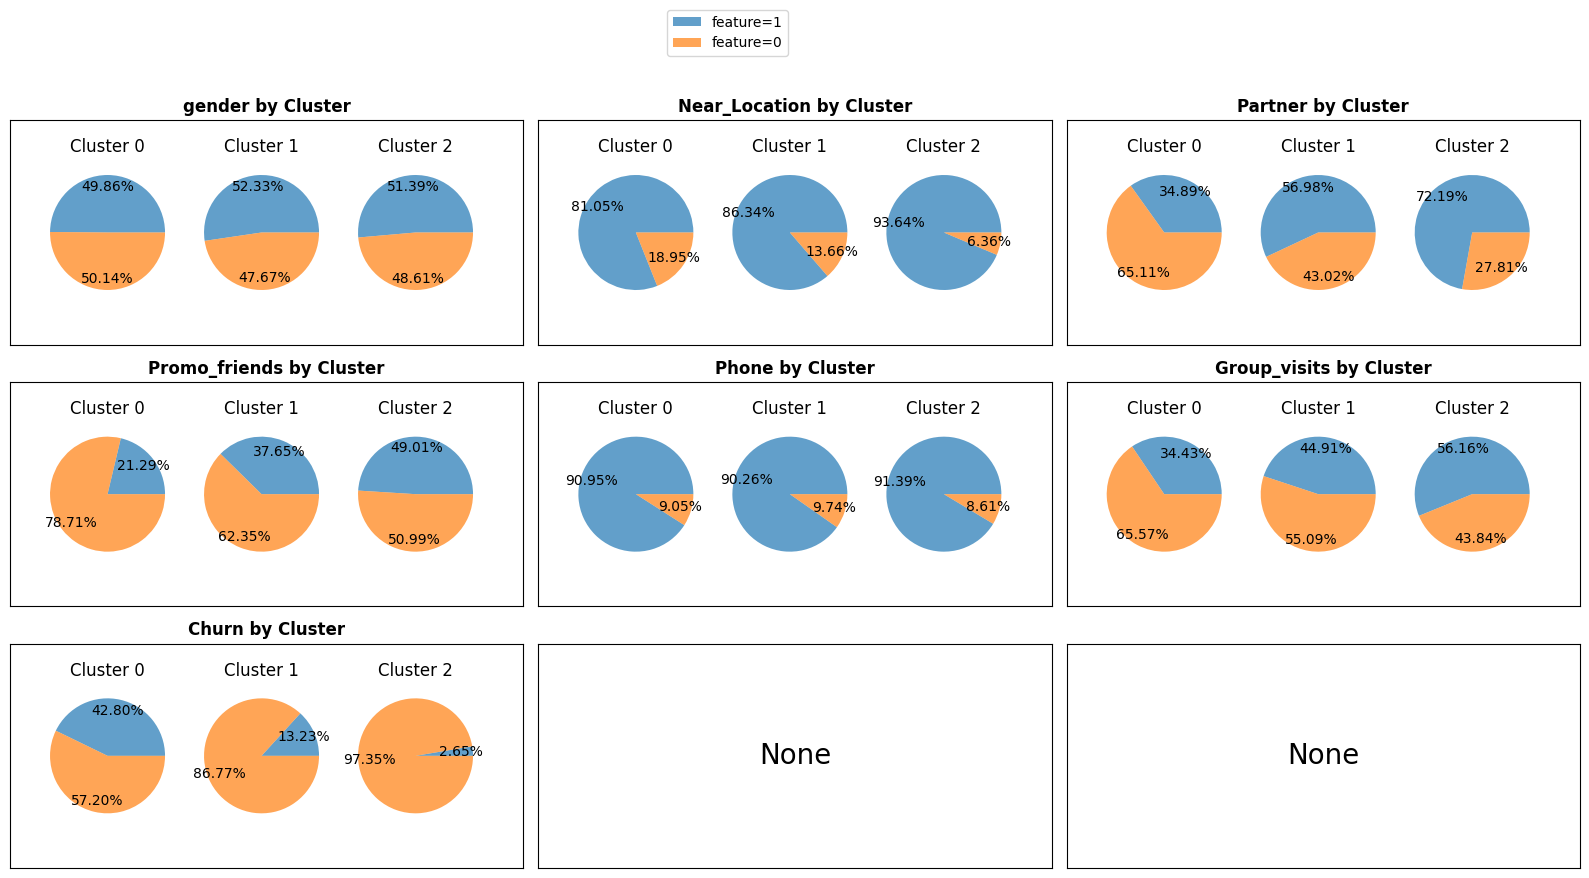

In [15]:
plot_pie(X_train_hard_clusters[binary_features+['Churn', 'Cluster']],  n_clusters=3, alpha=0.7, figsize=(16,8))
plt.show()

The key differences between clusers lie in `Near_location`, `Partner`, `Promo_friends`, `Group_visits`, and `Churn`. Clusters were generated using all features (`Churn` did not play a role in cluster generation).

### Cluster 0
* Less likely to live/work nearby
* Less likely to be affiliated with partner company
* Less likely to have singed up with friend promotion
* Less likely to have group visits in their plan
* Highest churn rate (42.80%)

### Cluster 1
* More likely than cluster 1 to live/work nearby
* More likely than cluster 1 to be affiliated with partner company
* More likely than cluster 1 to have signed up with friend promotion
* More likely than cluster 1 to have group visits in their memberhsip plan
* Moderate churn rate ( 13.23%)

### Cluster 2
* Highest likelihood of living/working nearby
* Highest likelihood of being affiliated with partner company
* Highest likelihood of having signed up using friend promotions
* Highest likelihood of having group visits in their plan
* Lowest churn rate (2.65%)

We can also analyze how confident we are in the classifications we made.

In [16]:
X_train_soft_clusters = X_train.copy()
X_train_soft_clusters[[f'cluster_{i}_prob' for i in range(3)]] = np.round(probs_train, 2)

X_train_soft_clusters

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,cluster_0_prob,cluster_1_prob,cluster_2_prob
Member_ID,,,,,,,,,,,,,,,,
1161,0,1,1,1,1,12,0,31,183.340029,11.0,8,3.590505,3.473680,0.0,0.0,1.0
2355,0,1,0,0,1,1,0,30,40.559417,1.0,26,1.663034,1.750301,1.0,0.0,0.0
1831,1,1,1,0,1,12,0,27,32.123604,12.0,5,1.060272,0.913766,0.0,0.0,1.0
156,0,1,1,1,1,6,0,26,54.694211,6.0,9,2.531159,2.446842,0.0,1.0,0.0
195,0,1,0,0,0,1,0,29,241.701674,1.0,4,1.690380,1.595065,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0,0,0,0,0,1,0,31,139.665457,1.0,3,2.104185,2.144784,1.0,0.0,0.0
3264,1,1,1,1,0,12,1,34,232.148448,10.0,9,1.330589,1.273503,0.0,0.0,1.0
1653,0,1,0,0,1,1,0,25,179.043886,1.0,3,1.128035,1.155351,1.0,0.0,0.0


In [17]:
X_train_soft_clusters[X_train_soft_clusters['cluster_0_prob']<0.95][X_train_soft_clusters[X_train_soft_clusters['cluster_0_prob']<=0.95]['cluster_0_prob']>0.05]

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,cluster_0_prob,cluster_1_prob,cluster_2_prob
Member_ID,,,,,,,,,,,,,,,,


We are vary confident about the predictions made for cluster 0. Members either have less than 5\% or more than 95\% likelihood of being a part of this cluster.

In [18]:
X_train_soft_clusters[X_train_soft_clusters['cluster_1_prob']<=0.95][X_train_soft_clusters[X_train_soft_clusters['cluster_1_prob']<=0.95]['cluster_1_prob']>=0.05].drop('cluster_0_prob', axis=1)[['cluster_1_prob', 'cluster_2_prob']]

,cluster_1_prob,cluster_2_prob
Member_ID,,
1013,0.12,0.88
1751,0.84,0.16
1520,0.27,0.73
1340,0.62,0.38
1132,0.24,0.76
2442,0.14,0.86
1365,0.85,0.15
604,0.06,0.94
2995,0.95,0.05


In [19]:
X_train_soft_clusters[X_train_soft_clusters['cluster_2_prob']<=0.95][X_train_soft_clusters[X_train_soft_clusters['cluster_2_prob']<=0.95]['cluster_2_prob']>=0.05][['cluster_1_prob', 'cluster_2_prob']]

,cluster_1_prob,cluster_2_prob
Member_ID,,
1013,0.12,0.88
1751,0.84,0.16
1520,0.27,0.73
1340,0.62,0.38
1132,0.24,0.76
2442,0.14,0.86
1365,0.85,0.15
604,0.06,0.94
2995,0.95,0.05


In [20]:
for i in range(probs_train.shape[0]):
    prob = probs_train[i,1:3]
    if (0.05 < prob[0] < 0.95) or (0.05 < prob[1] < 0.95):
        print(f'Member {X_train_soft_clusters.index[i]} has {prob[0]*100:.2f}% likelihood of being in cluster 1 and {prob[1]*100:.2f}% likelihood of being in cluster 2')

Member 1013 has 11.73% likelihood of being in cluster 1 and 88.27% likelihood of being in cluster 2
Member 1751 has 83.67% likelihood of being in cluster 1 and 16.33% likelihood of being in cluster 2
Member 1520 has 27.32% likelihood of being in cluster 1 and 72.68% likelihood of being in cluster 2
Member 1340 has 62.36% likelihood of being in cluster 1 and 37.64% likelihood of being in cluster 2
Member 1132 has 23.66% likelihood of being in cluster 1 and 76.34% likelihood of being in cluster 2
Member 2442 has 13.55% likelihood of being in cluster 1 and 86.45% likelihood of being in cluster 2
Member 1365 has 84.77% likelihood of being in cluster 1 and 15.23% likelihood of being in cluster 2
Member 604 has 5.52% likelihood of being in cluster 1 and 94.48% likelihood of being in cluster 2
Member 2995 has 94.69% likelihood of being in cluster 1 and 5.31% likelihood of being in cluster 2
Member 2897 has 65.35% likelihood of being in cluster 1 and 34.65% likelihood of being in cluster 2


On the other hand, we are not quite as confident in our predictions for clusters 1 and 2. There are 10 members who could not be placed into a cluster with more than 95% confidence. Most notably, members 1340 and 2897 have less than 70% likelihood of beloning to their most probable clusters according to the fitted model. Nevertheless, all members have higher than 60% likelihood of belonging to their most probable clusters according to the model.

## Conclusions

By creating clusters, we were able to segment the customerbase by their behaviors. These behavioral patterns can help us to more accurately identify whether a customer will leave the gym.

### Cluster 0: New Year's Resolutioners
* Most likely to leave the gym (42.80% churn rate)
* Shorter contract lengths (all one month)
* Least likely to live/work nearby
* Least likely to be affiliated with partner company
* Least likely to have singed up with friend promotion
* Least likely to have group visits in their plan

### Cluster 1: Average Gym Goer
* Moderate churn rate (13.23% churn rate)
* Moderate contract lenghts (mostly 6 month, few 12 month)
* More likely to live/work nearby than members in cluster 1
* More likely to be affiliated with partner company than members in cluster 1
* More likely to have singed up with friend promotion than members in cluster 1
* More likely to have group visits in their plan than members in cluster 1

### Cluster 2: Gym Junkie
* Least likely to leave the gym (2.65% churn rate)
* Longer contract lengths (all 12 month)
* Most likely to live/work nearby
* Most likely to be affiliated with partner company
* Most likely to have singed up with friend promotion
* Most likely to have group visits in their plan

### Save preprocessed data

In [21]:
X_test_norm = scaler.fit_transform(X_test)
X_test_pca = pca.transform(X_test_norm)
probs_test = gmm.predict_proba(X_test_pca)
X_test_soft_clusters = X_test.copy()
X_test_soft_clusters[[f'cluster_{i}_prob' for i in range(n_clusters)]] = np.round(probs_test, 2)

In [22]:
soft_clusters = pd.concat([X_train_soft_clusters,
                           X_test_soft_clusters])[[f'cluster_{i}_prob' for i in range(n_clusters)]]

soft_clusters.sort_index(inplace=True)
soft_clusters

,cluster_0_prob,cluster_1_prob,cluster_2_prob
Member_ID,,,
0,0.0,1.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0
...,...,...,...
3995,0.0,0.0,1.0
3996,1.0,0.0,0.0
3997,0.0,0.0,1.0


In [23]:
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns, index=X_train.index)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns, index=X_test.index)

In [24]:
X_preprocessed = pd.concat([X_train_norm,
                            X_test_norm])
X_preprocessed.sort_index(inplace=True)
X_preprocessed

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Member_ID,,,,,,,,,,,,,
0,0.0,0.0,1.0,1.0,-1.0,1.0,1.0,0.00,-0.853179,0.8,0.00,-1.338254,-1.102103
1,-1.0,0.0,0.0,0.0,0.0,2.2,1.0,0.30,-0.184701,2.2,1.00,0.063936,0.113248
2,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.25,-0.042225,0.0,-0.25,0.019442,0.014883
3,-1.0,0.0,1.0,1.0,0.0,2.2,1.0,1.00,-0.512229,2.2,-0.25,1.013723,1.057389
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.70,0.418462,0.0,0.00,-0.533447,-0.400480
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,1.0,0.0,0.0,2.2,0.0,0.70,-0.969450,2.2,1.25,0.330903,0.398553
3996,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,-0.468494,0.0,-0.50,-0.410255,-0.913725
3997,0.0,0.0,1.0,1.0,0.0,2.2,0.0,-0.25,-0.402568,2.0,-0.25,0.703974,0.719190


In [25]:
gym_data_preprocessed = pd.concat([X_preprocessed,
                                   soft_clusters,
                                   df['Churn']], axis=1)
gym_data_preprocessed.to_csv('data/gym_data_preprocessed.csv', index=True)
gym_data_preprocessed

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,cluster_0_prob,cluster_1_prob,cluster_2_prob,Churn
Member_ID,,,,,,,,,,,,,,,,,
0,0.0,0.0,1.0,1.0,-1.0,1.0,1.0,0.00,-0.853179,0.8,0.00,-1.338254,-1.102103,0.0,1.0,0.0,0
1,-1.0,0.0,0.0,0.0,0.0,2.2,1.0,0.30,-0.184701,2.2,1.00,0.063936,0.113248,0.0,0.0,1.0,0
2,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.25,-0.042225,0.0,-0.25,0.019442,0.014883,1.0,0.0,0.0,0
3,-1.0,0.0,1.0,1.0,0.0,2.2,1.0,1.00,-0.512229,2.2,-0.25,1.013723,1.057389,0.0,0.0,1.0,0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.70,0.418462,0.0,0.00,-0.533447,-0.400480,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,1.0,0.0,0.0,2.2,0.0,0.70,-0.969450,2.2,1.25,0.330903,0.398553,0.0,0.0,1.0,0
3996,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,-0.468494,0.0,-0.50,-0.410255,-0.913725,1.0,0.0,0.0,1
3997,0.0,0.0,1.0,1.0,0.0,2.2,0.0,-0.25,-0.402568,2.0,-0.25,0.703974,0.719190,0.0,0.0,1.0,0
